# Necesaary Imports

In [1]:
pip install torchsummary # this module is not installed already

Note: you may need to restart the kernel to use updated packages.


In [2]:
# necessary imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from matplotlib import style

# imports for making models
import torch
import torch.nn as nn
from torchsummary import summary  # for showing summary of the neural nets
from tqdm import tqdm # for showing progress bars

# taking images as input 
import os  # for setting up paths for images
from PIL import Image # reading images
import torchvision   # saving images
import albumentations as A  # for data augmentations
from albumentations.pytorch import ToTensorV2 # for converting np array to tensors

# Unzipping the dataset

In [3]:
! unzip /kaggle/input/carvana-image-masking-challenge/train_masks.zip; # it is a bash command to unzip the file

Archive:  /kaggle/input/carvana-image-masking-challenge/train_masks.zip
   creating: train_masks/
  inflating: train_masks/00087a6bd4dc_01_mask.gif  
 extracting: train_masks/00087a6bd4dc_02_mask.gif  
 extracting: train_masks/00087a6bd4dc_03_mask.gif  
 extracting: train_masks/00087a6bd4dc_04_mask.gif  
  inflating: train_masks/00087a6bd4dc_05_mask.gif  
  inflating: train_masks/00087a6bd4dc_06_mask.gif  
  inflating: train_masks/00087a6bd4dc_07_mask.gif  
  inflating: train_masks/00087a6bd4dc_08_mask.gif  
  inflating: train_masks/00087a6bd4dc_09_mask.gif  
  inflating: train_masks/00087a6bd4dc_10_mask.gif  
 extracting: train_masks/00087a6bd4dc_11_mask.gif  
  inflating: train_masks/00087a6bd4dc_12_mask.gif  
  inflating: train_masks/00087a6bd4dc_13_mask.gif  
  inflating: train_masks/00087a6bd4dc_14_mask.gif  
 extracting: train_masks/00087a6bd4dc_15_mask.gif  
 extracting: train_masks/00087a6bd4dc_16_mask.gif  
  inflating: train_masks/02159e548029_01_mask.gif  
 extracting: train

In [4]:
! unzip /kaggle/input/carvana-image-masking-challenge/train.zip;

Archive:  /kaggle/input/carvana-image-masking-challenge/train.zip
   creating: train/
  inflating: train/00087a6bd4dc_01.jpg  
  inflating: train/00087a6bd4dc_02.jpg  
  inflating: train/00087a6bd4dc_03.jpg  
  inflating: train/00087a6bd4dc_04.jpg  
  inflating: train/00087a6bd4dc_05.jpg  
  inflating: train/00087a6bd4dc_06.jpg  
  inflating: train/00087a6bd4dc_07.jpg  
  inflating: train/00087a6bd4dc_08.jpg  
  inflating: train/00087a6bd4dc_09.jpg  
  inflating: train/00087a6bd4dc_10.jpg  
  inflating: train/00087a6bd4dc_11.jpg  
  inflating: train/00087a6bd4dc_12.jpg  
  inflating: train/00087a6bd4dc_13.jpg  
  inflating: train/00087a6bd4dc_14.jpg  
  inflating: train/00087a6bd4dc_15.jpg  
  inflating: train/00087a6bd4dc_16.jpg  
  inflating: train/02159e548029_01.jpg  
  inflating: train/02159e548029_02.jpg  
  inflating: train/02159e548029_03.jpg  
  inflating: train/02159e548029_04.jpg  
  inflating: train/02159e548029_05.jpg  
  inflating: train/02159e548029_06.jpg  
  inflating:

# Helper functions
1. Forming the dataset.
2. Plotting the images and masks.
3. Making the dataloaders functions.

In [5]:
class dataset(torch.utils.data.Dataset):  # structure is inherited from pytorch Dataset class
    def __init__(self, images_dir, masks_dir, transform=None):
        super(dataset, self).__init__()
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images_list = os.listdir(images_dir)
        self.transform = transform
    
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.images_dir, self.images_list[index])   # setting up the path for image
        mask_path = os.path.join(self.masks_dir, self.images_list[index].replace('.jpg', '_mask.gif'))  # setting up path for mask
        image = np.array(Image.open(image_path).convert('RGB'))  # converting to default RGB format to which we are used to
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32) # converting to gray scale image for mask
        mask[mask==255.0] = 1.0  # mask will have values either equal to 0 or 255 so converting 255 to 1 for classification norms
        
        if self.transform is not None:  # data augmentation 
            augmentations = self.transform(image=image, mask=mask) # passing both images and mask to the same transform so that augmented images and masks still seem relevant
            image = augmentations['image']
            mask = augmentations['mask']
            
        return image, mask # dataset will be returned as tuple of lists first will be of images and second will be of masks
        

'''
# alternative method of generating the dataset, but it will be much slow
def dataset(images_dir, masks_dir, transform=None):
    data = []
    img_list = os.listdir(images_dir)
    for i in range(len(img_list)): # len(img_list)
        if i%100==0:
            print(f"{i} images processed")
        img_path = os.path.join(images_dir, img_list[i])
        mask_path = os.path.join(mask_dir, img_list[i].replace(".jpg", "_mask.jpg"))
        img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask=255.0] = 1.0
        
        if transform is not None:
            img = transform(img)
            mask = transform(img)
        
        
        #plt.subplot(1, 2, 1)
        #plt.imshow(img)
        #plt.axis('off')
        #plt.subplot(1, 2, 2)
        #plt.imshow(mask)
        #plt.axis('off')
        #plt.show()
        
        
        data.append((img, mask))
    
    return data
'''

# Model Building 

In [6]:
class block(nn.Module):
    # a building block of UNET representing the two convs on a step
    def __init__(self, in_channels, out_channels):
        super(block, self).__init__()
        all_layers = []
        all_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1))
        all_layers.append(nn.BatchNorm2d(out_channels))
        all_layers.append(nn.ReLU())
        
        all_layers.append(nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1))
        all_layers.append(nn.BatchNorm2d(out_channels))
        all_layers.append(nn.ReLU())

        self.model = nn.Sequential(*all_layers)
        
        
    def forward(self, x):
        return self.model(x)

In [7]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNET, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        # downsampling part
        self.block1 = block(in_channels=in_channels, out_channels=64)
        self.block2 = block(in_channels=64, out_channels=128)
        self.block3 = block(in_channels=128, out_channels=256)
        self.block4 = block(in_channels=256, out_channels=512)
        self.block5 = block(in_channels=512, out_channels=1024)
        # upsampling part
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.block6 = block(in_channels=1024, out_channels=512)
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.block7 = block(in_channels=512, out_channels=256)
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.block8 = block(in_channels=256, out_channels=128)
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.block9 = block(in_channels=128, out_channels=64)
        # final layer which maps the image into one channel
        self.final_layer = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
        
    
    
    def forward(self, x):
        # x - (3, 256, 256)
        # downsampling first
        skip1 = self.block1(x) # (64, 256, 256)
        skip2 = self.block2(self.pool(skip1)) # (128, 128, 128)
        skip3 = self.block3(self.pool(skip2)) # (256, 64, 64)
        skip4 = self.block4(self.pool(skip3)) # (512, 32, 32)
        op = self.block5(self.pool(skip4)) # (1024, 16, 16)
        # upsampling
        op = self.convt1(op) # (512, 32, 32)
        op = self.block6(torch.cat([skip4, op], 1)) # (512, 32, 32)
        
        op = self.convt2(op) # (256, 64, 64)
        op = self.block7(torch.cat([skip3, op], 1)) # (256, 64, 64)
        
        op = self.convt3(op) # (128, 128, 128)
        op = self.block8(torch.cat([skip2, op], 1)) # (128, 128, 128)
        
        op = self.convt4(op) # (64, 256, 256)
        op = self.block9(torch.cat([skip1, op], 1)) # (64, 256, 256)
        
        return self.final_layer(op) # (1, 256, 256)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
model = UNET(in_channels=3, out_channels=1).to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
             block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# UTILS

In [9]:
def save_checkpoint(state, filename='my_checkpoint.pth.tar'):
    # will save model and optimizer params at every epoch
    print("-> Saving CheckPoint")
    torch.save(state, filename)

In [10]:
def load_checkpoint(checkpoint, model):
    # it will just load, we can train it further, make changes to the architecture
    # and simply use it to predict
    print("-> Loading CheckPoint")
    model.load_state_dict(checkpoint["state_dict"])
    

In [11]:
def accuracy(loader, model, device='cuda'):
    # for an image accuracy can be number of correct pixels predicted, and for a batch it can be average over all the images
    # but at the same time simple accuracy is not a good metric to have as simply outputting all black pixels will lead to have an 80% accuracy 
    # so a better metric is dice score (idk what it is but let's just implement)
    correct_pixels = 0 
    total_pixels = 0
    dice_score = 0
    model.eval()  # so that dropout layers and batch_norm layers don't work 
    
    with torch.no_grad(): # so that no gradient calculation is done
        for x, y in loader: 
            x = x.to(device)
            y = y.to(device).unsqueeze(1) # so that both have a batch dimension 
            pred = torch.sigmoid(model(x)) # sigmoid wasn't in network, if multiple classes we would have implemented softmax and proceeded further
            pred = (pred>0.5).float() # will return bool and have to convert all of them to float
            correct_pixels+= (pred==y).sum()
            total_pixels+= torch.numel(pred) # just multiply all the dimension of the tensor
            dice_score+= (2*(pred*y).sum()/((pred+y).sum() + 1e-6)) # don't know what this means
        
    print(f"Validation accuracy is {(correct_pixels/total_pixels)*100}")
    print(f"Validation dice score is {dice_score/len(loader)}")
    # remember that both the metrics are for whole val_dataset
    model.train() # reactivating the training phase
                          

In [12]:
def save_predictions_as_images(loader, model, folder="saved_images/", device='cuda'):
    model.eval()
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader, 0): # this time i have enumerated the dataloader so that different batches get different names and names being differentiated by idx
            x = x.to(device)
            pred = torch.sigmoid(model(x))
            pred = (pred>0.5).float() # will return bool and have to convert all of them to float and also squeeze the dimension by 1
            torchvision.utils.save_image(pred, f"{folder}/pred_{idx}.png") # setting up the saving path
            torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/correct_{idx}.png") # setting up the saving path
    '''
    torchvision.utils.save_image() if given a batch of images will save images
    by grid or saying simply it will embed all images in a batch into one image.
    '''
    model.train()
            
            

# Training Loop


In [13]:
def train(loader, model, optimizer, loss_fn, scaler):
    '''
    it is the training procedure for one epoch of the network
    '''
    batches = tqdm(loader) # tqdm will be used to generate progress bars
    
    for idx, (inp, target) in enumerate(batches, 0):
        inp = inp.to(device)
        target = target.float().unsqueeze(1).to(device) # unsqueeze this to match the dimensions of the network and output
        
        # forward
        with torch.cuda.amp.autocast(): # for gradient underflowing and overflowing and it makes training faster by converting all floats to float16
            pred = model(inp)
            loss = loss_fn(pred, target) 
            
        optimizer.zero_grad()  # making all the previous gradients zero 
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        batches.set_postfix(loss = loss.item()) # loss of this current batch on current iteration 
        
        

# Driver Code

In [14]:
# hyperparameters
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_workers = 2
num_epochs = 3 # just for testing if loop works fine else i am gonna set it to 100
in_channels = 3
out_channels = 1 # it is two but for binary it is one

# setting up parameters for the dataset creation 
images_dir = "/kaggle/working/train"
masks_dir = "/kaggle/working/train_masks"
if not os.path.exists("/kaggle/working/saved_images"):
    os.mkdir(path="/kaggle/working/saved_images") # creating a directory for saving images and its predictions
train_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.Rotate(limit = 30, p=0.6),
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Normalize(
    mean = [0, 0, 0],
    std = [1, 1, 1], 
    max_pixel_value = 255.0),
    ToTensorV2() 
])

'''
# don't need this now as i am splitting the train_dataset into train and val
test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(
    mean = [0, 0, 0],
    std = [1, 1, 1], 
    max_pixel_value = 255.0),
    ToTensorV2() 
])
'''

# setting up the model, loss_fn, optimizer, scaler
model = UNET(in_channels=in_channels, out_channels=out_channels).to(device)
loss_fn = nn.BCEWithLogitsLoss() # cross entropy loss if there are multiple classes
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scaler = torch.cuda.amp.GradScaler()

# setting up the dataset and dataloaders and splitting the dataset into training and testing dataloaders
data = dataset(images_dir=images_dir, masks_dir=masks_dir, transform=train_transform) # dataset is ready 
percent = (len(data)*9)//10# let us take 90% data for training
train_data, test_data = torch.utils.data.random_split(data, [percent, len(data)-percent])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)


In [15]:
# now training 
for epoch in range(num_epochs):
    train(train_loader, model, optimizer, loss_fn, scaler)
    
    # save checkpoints 
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer':optimizer.state_dict()
    }
    save_checkpoint(checkpoint)
    # check accuracy 
    accuracy(test_loader, model)
    # check some examples 
    save_predictions_as_images(test_loader, model)
    
    

100%|██████████| 144/144 [02:37<00:00,  1.09s/it, loss=0.15]


-> Saving CheckPoint
Validation accuracy is 98.55184936523438
Validation dice score is 0.9664220809936523


100%|██████████| 144/144 [02:35<00:00,  1.08s/it, loss=0.139]


-> Saving CheckPoint
Validation accuracy is 99.22958374023438
Validation dice score is 0.9817107319831848


100%|██████████| 144/144 [02:38<00:00,  1.10s/it, loss=0.0942]


-> Saving CheckPoint
Validation accuracy is 99.2933120727539
Validation dice score is 0.9832658767700195


In [16]:
load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)
accuracy(test_loader, model)

-> Loading CheckPoint
Validation accuracy is 99.2958984375
Validation dice score is 0.9833163619041443


In [17]:
load_checkpoint(torch.load('my_checkpoint.pth.tar'), model)
accuracy(train_loader, model)

-> Loading CheckPoint
Validation accuracy is 99.2763671875
Validation dice score is 0.9829246997833252


In [18]:
# let us view the predictions
saved_dir = "/kaggle/working/saved_images"

pred_imgs_path = os.path.join(saved_dir, "pred_0.png")
orig_imgs_path = os.path.join(saved_dir, "correct_0.png")

pred_imgs = np.array(Image.open(pred_imgs_path))
orig_imgs = np.array(Image.open(orig_imgs_path))



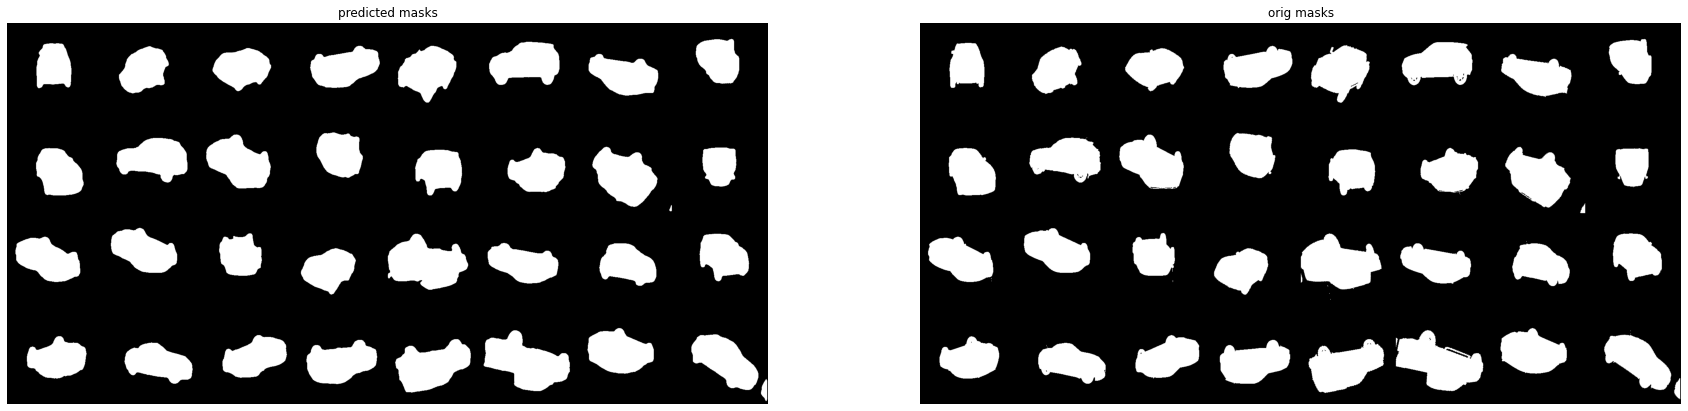

In [19]:
figure = plt.figure(figsize=(30, 30))
plt.subplot(1, 2, 1)
plt.imshow(pred_imgs)
plt.axis('off')
plt.title("predicted masks")
plt.subplot(1, 2, 2)
plt.imshow(orig_imgs)
plt.axis('off')
plt.title("orig masks")
plt.show()

In [20]:
# it's all working fine